In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
#from statsmodels.genmod.families import NegativeBinomial, Gamma
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import statsmodels.api as sm
import statsmodels.formula.api as smf
import anndata as ad

from scipy.stats import expon, nbinom, norm, poisson
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")


# now the DCIS count data is found in an RDA file, which we apparently read using 'pyreadr'
import pyreadr

import os

# thread issues
os.environ['OMP_NUM_THREADS'] = '10'  # Limit to 1 thread
os.environ['MKL_NUM_THREADS'] = '10'  # Limit to 1 thread for MKL (if used)
os.environ['NUMEXPR_NUM_THREADS'] = '10'  # Limit to 1 thread for NumExpr (if used)



# to convert Ensemble to Refseq gene names
gene_convert = pyreadr.read_r('/path/to/ensemble_to_refseq_gene_name_table.rds')
gene_convert = gene_convert[None]
id_to_name = {gene_id: gene_name for gene_id, gene_name in zip(gene_convert["gene_id"], gene_convert["gene_name"])}


In [2]:
### Parameters ###

# whether or not we're doing outlier removal using trimmed means
trim_means_flag = False
trim_percent = 1 # 1% usually gets rid of most extreme outliers

# genes must be expressed in this % of patients (between 0-1)
express_percent_limit = 0.0 # set to 0 if you want patient stats (all genes with at least 1 read), set to 0.2 if we want AIC stats of genes with >20% expression

# library adjust (using fractional method)
adjust_for_lib = False

no_ZI_AICs = False


In [3]:
# adjust for library sizes
def library_adjust(data):
    if (adjust_for_lib):
        library_size = data.sum(axis=0)
        
        cleaned_matrix = np.round((data /library_size)*10000000)
        return cleaned_matrix
    else:
        return data

In [27]:
# a function to compute NB parameters
def neg_log_likelihood(params, values):
    r, p = params
    # Convert p to the form used by scipy nbinom function
    prob = r / (r + values.mean())
    # Calculate the negative log likelihood
    nll = -np.sum(nbinom.logpmf(values, r, prob))
    return nll


def estimate_nb_parameters(row):
    # Calculate the sample mean and variance

    n = len(row)
    if (trim_means_flag):
        elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
        sorted_data = np.sort(row)
        
        if (elements_to_trim > 0):
            row = sorted_data[elements_to_trim:-elements_to_trim]
        else: 
            row = sorted_data

    # to avoid low expressed datasets which lead to very high thetas
    if (sum(row) <= 1):
        return (None, None, None)

    # Estimate mu and theta
    mean_counts = np.mean(row)
    variance_counts = np.var(row, ddof=1)  # Use ddof=1 for sample variance
    mu = mean_counts

    if (variance_counts > mean_counts):
        theta = (mean_counts ** 2) / (variance_counts - mean_counts)

        if (theta < -10):
            theta = -10
        rejected = 0
    else:
        #print("Rejected assumption.")
        rejected = 1
        return (None, None, None)

    #initial_params = [1, 0.5]
    #result = minimize(neg_log_likelihood, initial_params, method='L-BFGS-B', args=(row,), bounds=((1e-5, None), (1e-5, 1-1e-5)))

    #r_est, p_est = result.x
    #theta_est = r_est / p_est - r_est
    X = np.ones_like(row)  # This creates a design matrix with a single column of ones

    # Fit the Negative Binomial model
    #model = sm.GLM(row, X, family=sm.families.NegativeBinomial()).fit()
    #mu_2 = model.fittedvalues
    #alpha = model.scale  # This is often used as the dispersion parameter
    #theta_est = 1 / alpha
    #confidence_intervals = model.conf_int()
    #print(confidence_intervals)

    #X = np.ones((len(row), 1))
    #nb_model = NegativeBinomial(row, X).fit()
    #conf_intervals = nb_model.conf_int()

    
    #alpha_mle = nb_model.params['alpha']
    #theta_mle = 1 / alpha_mle
    #print(f"Theta (MLE): {theta_mle}")
    theta_mle = 0

   # def nb_pmf(counts, mu, theta):
        # Convert mu and theta to the 'n' and 'p' parameters of scipy's nbinom
        # n corresponds to the number of successes (theta)
        # p corresponds to theta / (mu + theta)
   #     n = theta
   #     p = theta / (mu + theta)
   #     pmf = nbinom.pmf(counts, n, p)
   #     return pmf

    #count_range = np.arange(0, row.max() + 1)
    # Calculate PMF values using Method of Moments estimate
    #pmf_mom = nb_pmf(count_range, mean_counts, theta)

    # Calculate PMF values using MLE estimate
    #pmf_mle = nb_pmf(count_range, mean_counts, theta_mle)

    # Step 5: Plot the histogram of counts data
    #plt.figure(figsize=(10, 6))
    #plt.hist(row, bins=range(int(row.min()), int(row.max()) + 2), 
    #        density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed Counts')

    # Step 6: Overlay the NB fits from both estimations
    #plt.plot(count_range, pmf_mom, 'o-', label=f'NB Fit (MoM θ={theta:.2f})')
    #plt.plot(count_range, pmf_mle, 's-', label=f'NB Fit (MLE θ={theta_mle:.2f})')

    # Customize the plot
    #plt.xlabel('Count')
    #plt.ylabel('Probability')
    #plt.title('Negative Binomial Fit to Count Data')
    #plt.legend()
    #plt.xlim(0, 100)
    #plt.grid(True)
    #plt.show()

    if (theta > 1000) and (theta_mle > 1000):
        print("Giant Theta! (both)")
        return (mu,100,100)
    elif (theta > 1000):
        print("Giant Theta! (MOM)")
        return (mu,100,theta_mle)
    elif (theta_mle > 1000):
        print("Giant Theta! (MLE)")
        return (mu,theta,100)

    return (mu, theta, theta_mle)

In [ ]:
# Our dataset!
all_counts = pyreadr.read_r('/path/to/dcis/expression_counts.Jan2023_1_2_and_2_2.rds')
vst_norm = pyreadr.read_r('/path/to/dcis/expression_VST_Normalized.Jan2023_1_2_and_2_2.rds')

# this data is loading without issue
ship_data = pyreadr.read_r('/path/to/dcis/ship1_2_full_tbl.Jan2023.With_Stroma_Assignment.rds')
# I wish that we could've simply used the RDA, but the counts-only RDS works and loads faster so what can you do
# in the future, could try the package 'rpy2' instead, it's an alternative that requires R but that's okay for us

# now we want to isolate just the expression from a particular type of tissue
df = all_counts[None] # load all_counts into a pandas data frame

# Eliminate any samples in the blacklist
ship_df = ship_data[None]
#print(ship_df['blacklist'].value_counts()) # they're all false

# since ship_data already has patients filtered out, lets filter out any patient who isn't on the list
# match by 'sample_name'
df_blacklist_filtered = df[ship_df['sample_name']]

# split the patients by tissue
count_DCIS = df_blacklist_filtered.filter(like='_D')
count_STROMA = df_blacklist_filtered.filter(like='_S')
count_NORMAL = df_blacklist_filtered.filter(like='_N')

# if we want consistency between the 3 sample types
vst_table = vst_norm[None] # we don't apply this anymore because it blocks any gene with >80% frac_zero
filtered_norm_count = count_NORMAL#[count_NORMAL.index.isin(vst_table.index)]
filtered_tumour_count = count_DCIS#[count_DCIS.index.isin(vst_table.index)]
filtered_stroma_count = count_STROMA#[count_STROMA.index.isin(vst_table.index)]

filtered_norm_count_libadjust = library_adjust(filtered_norm_count)
fraction_of_zeroes = (filtered_norm_count_libadjust == 0).mean(axis=1)
filtered_norm_count = filtered_norm_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_tumour_count_libadjust = library_adjust(filtered_tumour_count)
fraction_of_zeroes = (filtered_tumour_count_libadjust == 0).mean(axis=1)
filtered_tumour_count = filtered_tumour_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_stroma_count_libadjust = library_adjust(filtered_stroma_count)
fraction_of_zeroes = (filtered_stroma_count_libadjust == 0).mean(axis=1)
filtered_stroma_count = filtered_stroma_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


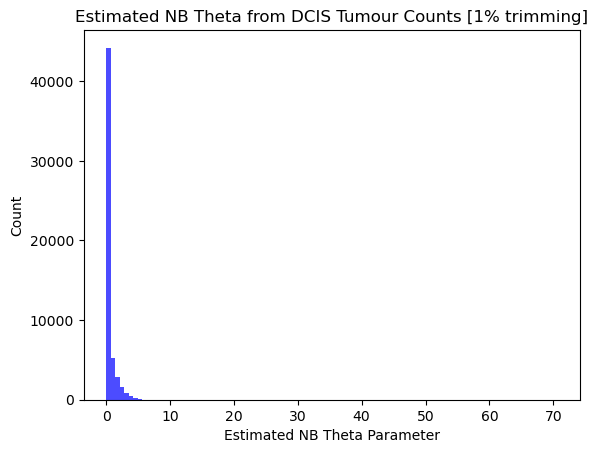

Mean: 0.4760684190375399 0.0 904.550193534767
Median: 0.12084828230457284 0.0 6.05527272727273
Stdev: 0.8543629659411551 0.0 28928.901332825175
Min, Max, Over10, Under0, Total
0.004548318726012508 70.5990894989172 3 0 55442 0.005411060207063237
8685 55442 0.1566501929944807
18529 55442 0.3342051152555824
theta 0.1 to 1 20999 55442 0.37875617762706976
theta 0.1 to 10 29563 55442 0.5332239096713682
theta 0.005 to 1 7347 55442 0.13251686447097868
Min, Max, Over10, Under0, Total
0 0 0 0 55442 0.0
95% Percentiles: 0.006984905172668315, 2.9311439639904537


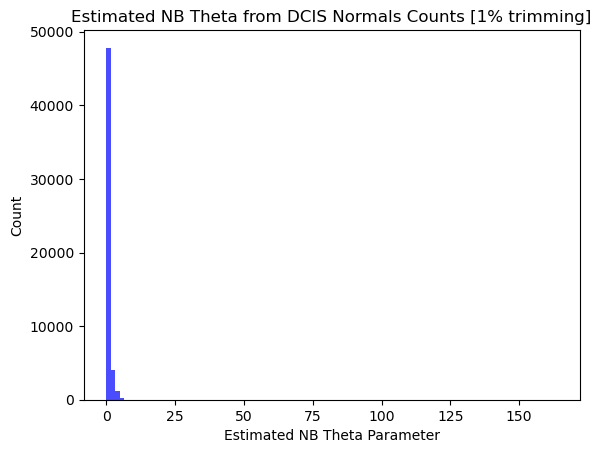

Mean: 0.5636023144910536 0.0 1031.4429744862955
Median: 0.15891296003988423 0.0 8.552722772277228
Stdev: 1.1950267447592515 0.0 21107.16150148055
Min, Max, Over10, Under0, Total
0.009902056671249413 163.76235871058714 5 0 53366 0.009369261327436944
4354 53366 0.08158752763932092
13862 53366 0.25975340104186184
theta 0.1 to 1 22314 53366 0.41813139452085596
theta 0.1 to 10 31662 53366 0.5932991042986171
theta 0.005 to 1 7837 53366 0.14685380204624668
Min, Max, Over10, Under0, Total
0 0 0 0 53366 0.0
95% Percentiles: 0.013174557411509656, 3.3805154830797703
Giant Theta! (MOM)


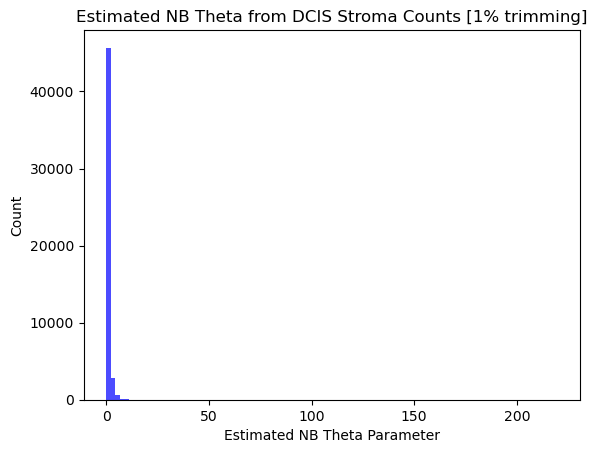

Mean: 0.6244860701259655 0.0 1187.3051638219397
Median: 0.19064037801476957 0.0 9.907692307692308
Stdev: 1.549851764468373 0.0 21897.400071327767
Min, Max, Over10, Under0, Total
0.015386343410604882 219.5908771849104 28 0 49304 0.056790524095408086
2705 49304 0.05486370274217102
11170 49304 0.2265536264806101
theta 0.1 to 1 22402 49304 0.45436475742333277
theta 0.1 to 10 31305 49304 0.6349383417166964
theta 0.005 to 1 6801 49304 0.1379401265617394
Min, Max, Over10, Under0, Total
0 0 0 0 49304 0.0
95% Percentiles: 0.016923076923076923, 3.810634457203153


In [28]:
#re_filtered_tumour_count = filtered_tumour_count.iloc[1:-1]

computed_values_nb = filtered_tumour_count.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)



plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from DCIS Tumour Counts [1% trimming]")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))


count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


# NORMALS
computed_values_nb = filtered_norm_count.apply(lambda row: estimate_nb_parameters(row), axis=1)

computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)


plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from DCIS Normals Counts [1% trimming]")
plt.show()


print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))

counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


#STROMA

computed_values_nb = filtered_stroma_count.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from DCIS Stroma Counts [1% trimming]")
plt.show()


print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


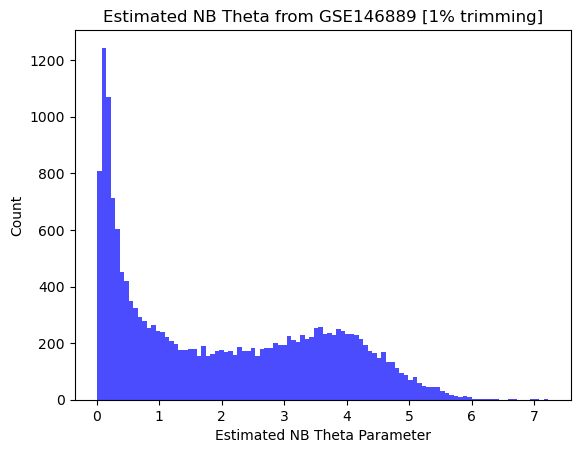

Mean: 1.9992006487042124 0.0 1775.701162879662
Median: 1.6996410695500608 0.0 420.42857142857144
Stdev: 1.6315230546544646 0.0 6361.847664707731
Min, Max, Over10, Under0, Total
0.011089579789241343 7.223652523583122 0 0 18241 0.0
154 18241 0.008442519598706212
455 18241 0.02494380790526835
theta 0.1 to 1 6158 18241 0.33759114083657693
theta 0.1 to 10 17154 18241 0.9404089688065347
theta 0.005 to 1 632 18241 0.03464722328819692
Min, Max, Over10, Under0, Total
0 0 0 0 18241 0.0
95% Percentiles: 0.05019342221795215, 5.054507150122398


In [ ]:
import anndata as ad
path = "/path/to/third_party/GSE146889_third_party_ffpe/train/GSE146889_19K_tumor.tau_1.h5ad"
adata = ad.read_h5ad(path)

#print(adata.obs)

expression = adata.X
expression_t = pd.DataFrame(expression.T)

#print(expression_t.shape)

# what happened to express_percent_limit
filtered_count_libadjust = library_adjust(expression_t)
fraction_of_zeroes = (filtered_count_libadjust == 0).mean(axis=1)
expression_t = filtered_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = expression_t.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)


plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE146889 [1% trimming]")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


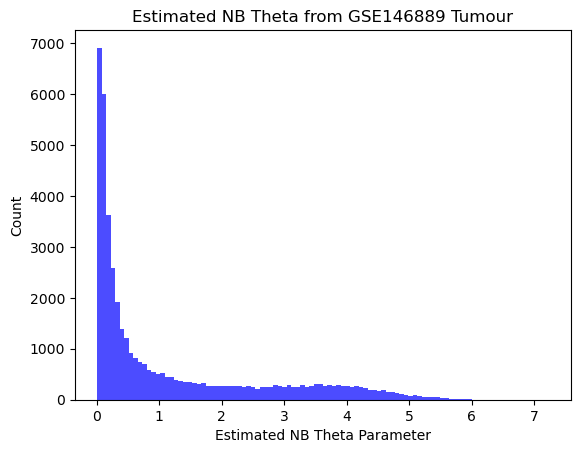

Mean: 1.1732412822630907 0.0 892.360107440746
Median: 0.4166652417394069 0.0 7.527472527472527
Stdev: 1.4378647489049905 0.0 8049.7534971103605
95% Percentiles: 0.021978021978022007, 4.6838965017088015


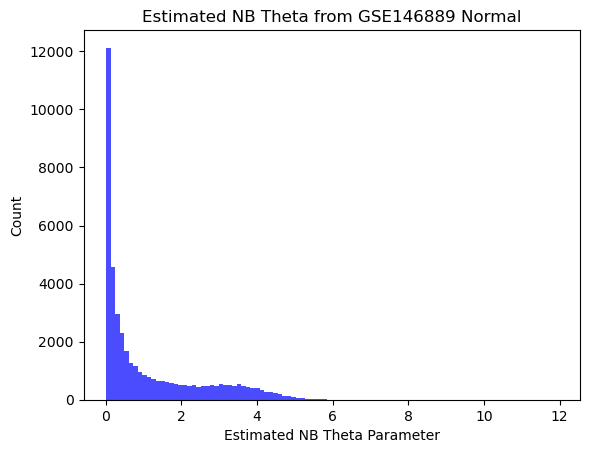

Mean: 1.1398167190003665 0.0 958.0337166335685
Median: 0.4587028904756899 0.0 7.2823529411764705
Stdev: 1.3548773378332315 0.0 9779.53408213955
95% Percentiles: 0.021177598941635935, 4.410557893617146


In [25]:
## here, we will repeat our plots but for a different data set
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE146889_third_party_ffpe/GSE146889_GeneCount.rds')
df = all_counts[None] # load all_counts into a pandas data frame


# we need to split the tumors and normals by name
count_TUMOR = df.filter(like='tumor')
count_NORMAL = df.filter(like='normal')


# adjust for library size (fraction method)
count_TUMOR_libadjust = library_adjust(count_TUMOR)

fraction_of_zeroes = (count_TUMOR_libadjust == 0).mean(axis=1)
filtered_tumour = count_TUMOR_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = filtered_tumour.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)


plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE146889 Tumour")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")



count_NORMAL_libadjust = library_adjust(count_NORMAL)

fraction_of_zeroes = (count_NORMAL_libadjust == 0).mean(axis=1)
filtered_normal = count_NORMAL_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

computed_values_nb = filtered_normal.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)


plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE146889 Normal")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


(18811, 528)


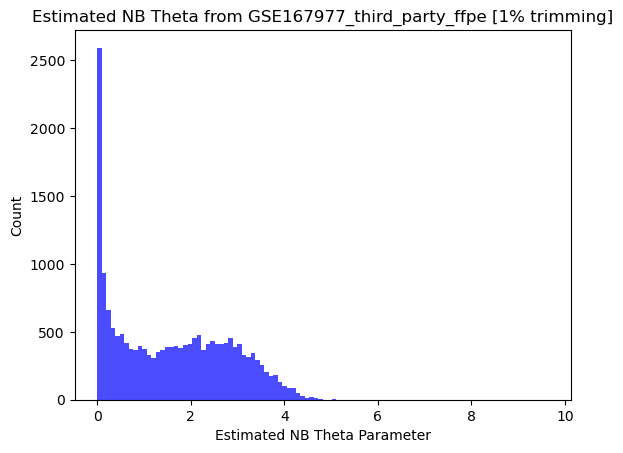

Mean: 1.5955466350196308 0.0 673.9501613638399
Median: 1.5356715184079535 0.0 148.52272727272728
Stdev: 1.2343422065441634 0.0 3240.272992289949
Min, Max, Over10, Under0, Total
0.0019058509624547335 9.64208118924752 0 0 18615 0.0
1002 18615 0.05382755842062852
1816 18615 0.09755573462261617
theta 0.1 to 1 4749 18615 0.25511684125705075
theta 0.1 to 10 16001 18615 0.8595756110663444
theta 0.005 to 1 798 18615 0.042868654311039485
Min, Max, Over10, Under0, Total
0 0 0 0 18615 0.0
95% Percentiles: 0.007700287826363769, 3.9083486511267793


In [ ]:
path = "/path/to/third_party/GSE167977_third_party_ffpe/train/GSE167977_19K.EJM_Fixed_2.tau_1.h5ad"
adata = ad.read_h5ad(path)
#print(adata.obs)

expression = adata.X
expression_t = pd.DataFrame(expression.T)

print(expression_t.shape)

filtered_count_libadjust = library_adjust(expression_t)
fraction_of_zeroes = (filtered_count_libadjust == 0).mean(axis=1)
expression_t = filtered_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = expression_t.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE167977_third_party_ffpe [1% trimming]")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum(nb_theta > 10)
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


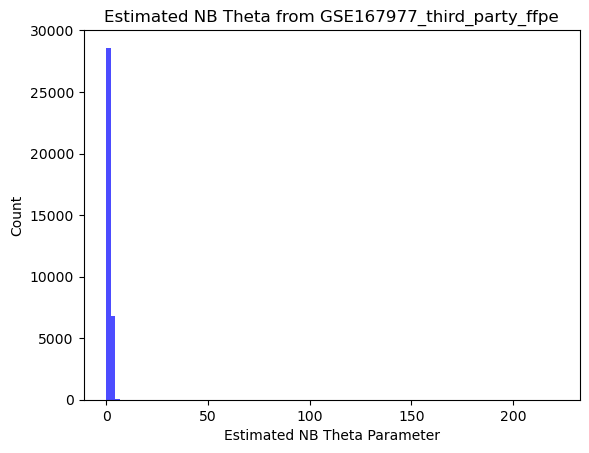

Mean: 1.123617158741264 0.0 395.7767387271379
Median: 0.6392903739101434 0.0 4.399621212121212
Stdev: 2.03843435343518 0.0 4505.147319829523
95% Percentiles: 0.005064787484153485, 3.7314113500043327


In [29]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE167977_third_party_ffpe/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

# filter and compute dispersion
# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)

tumours_counts.set_index('ensembl_gene_id', inplace=True)
#tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns

row_means = tumours_counts.mean(axis=1)


# adjust for library size (fraction method)
# should come before the gene filter
tumours_counts_lib_adjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_lib_adjust == 0).mean(axis=1)
filtered_df = tumours_counts_lib_adjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

computed_values_nb = filtered_df.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE167977_third_party_ffpe")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


                                                  batch
X140324_UNC13.SN749_0335_AC3LP4ACXX_ATCACG_L005       1
X140324_UNC13.SN749_0335_AC3LP4ACXX_CGATGT_L006       1
X140324_UNC13.SN749_0335_AC3LP4ACXX_TGACCA_L005       1
X140324_UNC13.SN749_0335_AC3LP4ACXX_TTAGGC_L006       1
X140624_UNC12.SN629_0375_AC4K57ACXX_ACAGTG_L007       1
...                                                 ...
X150916_UNC17.D00216_0344_AC6P3BANXX_ATTCCT_L001      1
X150916_UNC17.D00216_0344_AC6P3BANXX_CAGATC_L002      1
X150916_UNC17.D00216_0344_AC6P3BANXX_GTTTCG_L003      1
X151005_UNC18.D00493_0265_AC7JERANXX_GATCAG_L002      1
X151005_UNC18.D00493_0265_AC7JERANXX_TAGCTT_L002      1

[97 rows x 1 columns]
(16525, 97)


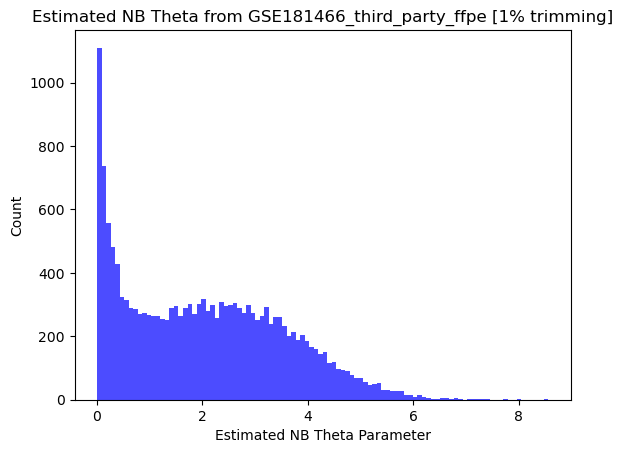

Mean: 2.0446672051391177 0.0 1027.118864254084
Median: 1.9378622833573202 0.0 386.62886597938143
Stdev: 1.4989200985589088 0.0 2669.3153632517583
Min, Max, Over10, Under0, Total
0.010500190912561998 8.559321102817254 0 0 16492 0.0
74 16492 0.004487024011642009
511 16492 0.03098471986417657
theta 0.1 to 1 4082 16492 0.24751394615571187
theta 0.1 to 10 15339 16492 0.9300873150618482
theta 0.005 to 1 642 16492 0.03892796507397526
Min, Max, Over10, Under0, Total
0 0 0 0 16492 0.0
95% Percentiles: 0.045485324866648476, 5.117132393685975


In [ ]:
path = "/path/to/third_party/GSE181466_third_party_ffpe/train/old/GSE181466_19K.tau_1.h5ad"
adata = ad.read_h5ad(path)

print(adata.obs)

expression = adata.X
expression_t = pd.DataFrame(expression.T)

print(expression_t.shape)

filtered_count_libadjust = library_adjust(expression_t)
fraction_of_zeroes = (filtered_count_libadjust == 0).mean(axis=1)
expression_t = filtered_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = expression_t.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE181466_third_party_ffpe [1% trimming]")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


Min, Max, Over10, Under0, Total
-1.1546391752577359 8.559321102817254 0 1 16525 0.0

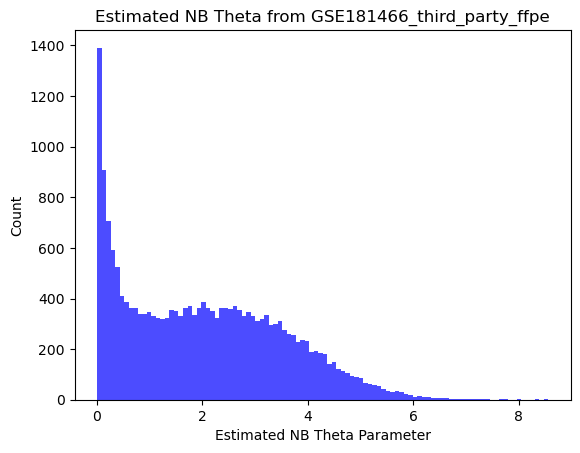

Mean: 2.024773257394125 0.0 1007.8454704627758
Median: 1.901339180803289 0.0 321.5923195876288
Stdev: 1.499380232584704 0.0 6741.411835573566
95% Percentiles: 0.044086691978489086, 5.111671859278495


In [30]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE181466_third_party_ffpe/GSE181466_rsem_genes_matrix-97.txt',
                  delimiter='\t')

# patient information splitting is unnecessary, this appears to all be both FFPE and from tumours
# there is subtype and age information in the series matrix file, if we're interested

# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
# removing gene column at position 0
tumours_counts.set_index('Unnamed: 0', inplace=True)
#tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1)
# skip genes that are all zeroes, or just one spurrious read somewhere

# adjust for library size (fraction method)
tumours_counts_libadjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = filtered_df.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE181466_third_party_ffpe")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


(18790, 165)


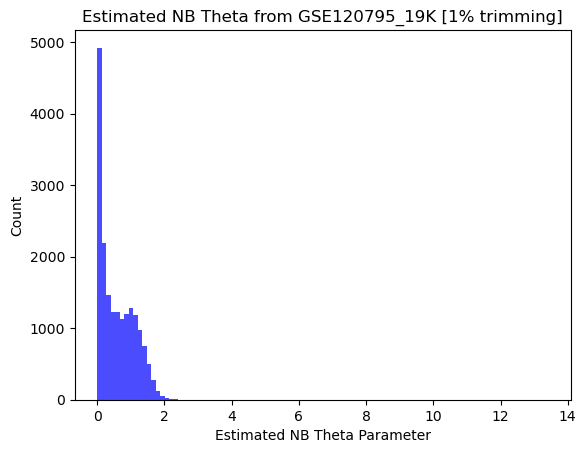

Mean: 0.5980344429414993 0.0 428.94589651235447
Median: 0.4809699419246809 0.0 135.330303030303
Stdev: 0.5099502503113251 0.0 3514.187686913296
Min, Max, Over10, Under0, Total
0.006084751901484968 13.418181818175965 1 0 18526 0.005397819281010472
437 18526 0.023588470258015762
2047 18526 0.11049336068228435
theta 0.1 to 1 9978 18526 0.5385944078592249
theta 0.1 to 10 14646 18526 0.7905646118967937
theta 0.005 to 1 1832 18526 0.09888804922811184
Min, Max, Over10, Under0, Total
0 0 0 0 18526 0.0
95% Percentiles: 0.02077853997310245, 1.624404667236738


In [ ]:
# AnnData X will have to be flipped so each row is a gene
path = "/path/to/third_party/GSE120795_third_party_ffpe/train/GSE120795_19K.EJM_Fixed.tau_1.h5ad"
adata = ad.read_h5ad(path)

expression = adata.X.astype(float)
expression_t = pd.DataFrame(expression.T)

print(expression_t.shape)

filtered_count_libadjust = library_adjust(expression_t)
fraction_of_zeroes = (filtered_count_libadjust == 0).mean(axis=1)
expression_t = filtered_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = expression_t.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE120795_19K [1% trimming]")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0) 
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


Min, Max, Over10, Under0, Total
-1.1926380368098115 16.10061349693265 1 23 18790 0.005321979776476849

(58233, 147)


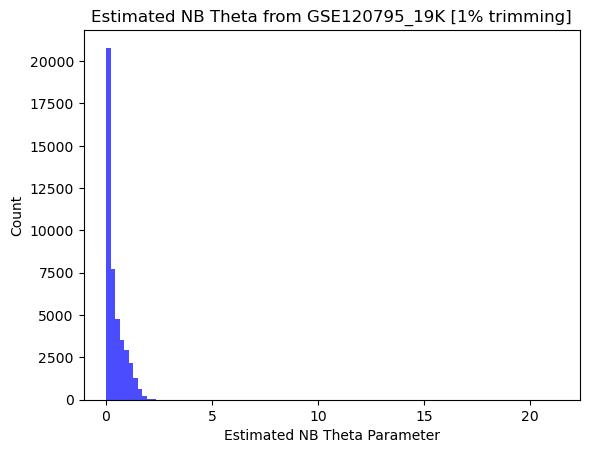

Mean: 0.4134134796552611 0.0 200.0355122075522
Median: 0.2484365384952075 0.0 3.17687074829932
Stdev: 0.4416264614202554 0.0 3102.981200063424
95% Percentiles: 0.013605442176870803, 1.4574968198661626


In [31]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE120795_third_party_ffpe/GSE120795_total_norms_raw_counts.tsv',
                  delimiter='\t')

# in the series matrix"disease: healthy", 
patient_info = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE120795_third_party_ffpe/GSE120795_cell_info.txt',
                  delimiter='\t')

# this filter is present because those filtered out were not FFPE (blood and bone marrow)
mask = patient_info.iloc[0] == "healthy"

filtered_data = patient_info.loc[:, mask]
patient_names = filtered_data.columns
column_names_with_extension = [name + ".fastq.gz" for name in patient_names]
column_names_with_extension = column_names_with_extension[1:]

# Assuming 'second_list' is the list where you want to filter based on column names
filtered_data = data[column_names_with_extension]
ffpe_counts = pd.DataFrame(filtered_data)
#filtered_data = ffpe_counts[ffpe_counts.sum(axis=1) > 1]
print(ffpe_counts.shape)


ffpe_counts_libadjust = library_adjust(ffpe_counts)
fraction_of_zeroes = (ffpe_counts_libadjust == 0).mean(axis=1)
filtered_data = ffpe_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

computed_values_nb = filtered_data.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE120795_19K")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")



                    batch subtype tnbc_subtype source      tumour      tissue  \
AUR.AFEA.TTP1.A.1.0  FFPE   Basal          UNS   FFPE     Primary      Breast   
AUR.AFEA.TTM4.A.1.1    FF   Basal          BL1     FF  Metastasis  Lymph node   
AUR.AFEA.TTM2.A.1.1    FF   Basal          BL1     FF  Metastasis       Brain   
AUR.AFEA.TTM1.A.1.1    FF   Basal          UNS     FF  Metastasis       Brain   
AUR.AFEA.TTM3.A.1.1    FF   Basal          BL1     FF  Metastasis        Lung   
...                   ...     ...          ...    ...         ...         ...   
AUR.AD9H.TTM2.A.1.1    FF    LumB      notTNBC     FF  Metastasis       Liver   
AUR.AD9F.TTM3.A.1.1    FF    LumB      notTNBC     FF  Metastasis     Adrenal   
AUR.AD9F.TTM1.A.1.1    FF    LumB      notTNBC     FF  Metastasis       Liver   
AUR.AD9F.TTM2.A.1.1    FF    LumA      notTNBC     FF  Metastasis  Lymph node   
AUR.AFUG.TTM1.A.1.1    FF    Her2      notTNBC     FF  Metastasis       Chest   

                         tr

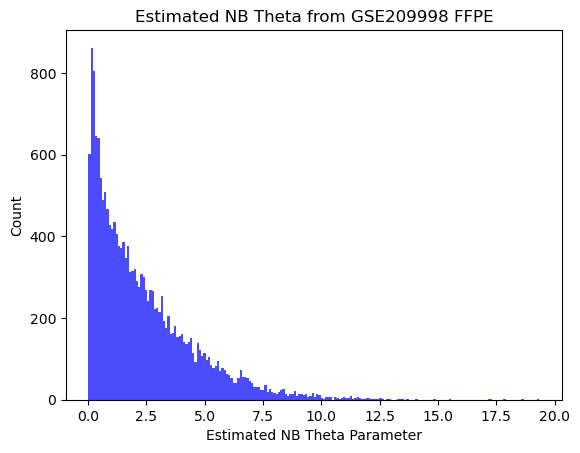

Mean: 2.348480966076403 0.0 1204.5777017248918
Median: 1.7435511546019324 0.0 418.0833333333333
Stdev: 2.1319825555319736 0.0 3523.8208331713995
Min, Max, Over10, Under0, Total
0.028388666963730425 19.339142631731395 111 0 18043 0.6151970293188493
0 18043 0.0
123 18043 0.006817048162722385
theta 0.1 to 1 5583 18043 0.3094274788006429
theta 0.1 to 10 17500 18043 0.9699052264035914
theta 0.005 to 1 309 18043 0.0171257551404977
Min, Max, Over10, Under0, Total
0 0 0 0 18043 0.0
95% Percentiles: 0.10220654084082617, 7.771691617909604
(18098, 87)


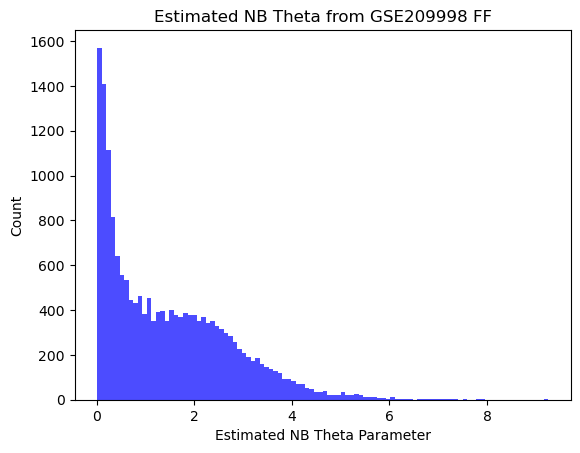

Mean: 1.4589497071426627 0.0 2378.885867033261
Median: 1.17694703331981 0.0 876.448275862069
Stdev: 1.261221521517794 0.0 7212.1717548505385
Min, Max, Over10, Under0, Total
0.011555683507537709 9.256708966451006 0 0 18060 0.0
91 18060 0.0050387596899224806
605 18060 0.03349944629014397
theta 0.1 to 1 6745 18060 0.37347729789590256
theta 0.1 to 10 16557 18060 0.9167774086378737
theta 0.005 to 1 898 18060 0.049723145071982285
Min, Max, Over10, Under0, Total
0 0 0 0 18060 0.0
95% Percentiles: 0.042252458878170106, 4.339660276334123


In [ ]:
# AnnData X will have to be flipped so each row is a gene
path = "/path/to/third_party/GSE209998_third_party_ffpe/train/GSE209998_19K.EJM_Fixed.tau_1.h5ad"
adata = ad.read_h5ad(path)
print(adata.obs)
ffpe_samples = adata[adata.obs['batch'] == 'FFPE']
ff_samples = adata[adata.obs['batch'] == 'FF']

# FFPE 
expression = ffpe_samples.X.astype(float)
expression_t = pd.DataFrame(expression.T)

print(expression_t.shape)

filtered_count_libadjust = library_adjust(expression_t)
fraction_of_zeroes = (filtered_count_libadjust == 0).mean(axis=1)
expression_t = filtered_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = expression_t.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=200, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE209998 FFPE")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


# FF
expression = ff_samples.X.astype(float)
expression_t = pd.DataFrame(expression.T)

print(expression_t.shape)

filtered_count_libadjust = library_adjust(expression_t)
fraction_of_zeroes = (filtered_count_libadjust == 0).mean(axis=1)
expression_t = filtered_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = expression_t.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE209998 FF")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


-1.157024793388426 9.700838062739589 0 4 18098 0.0

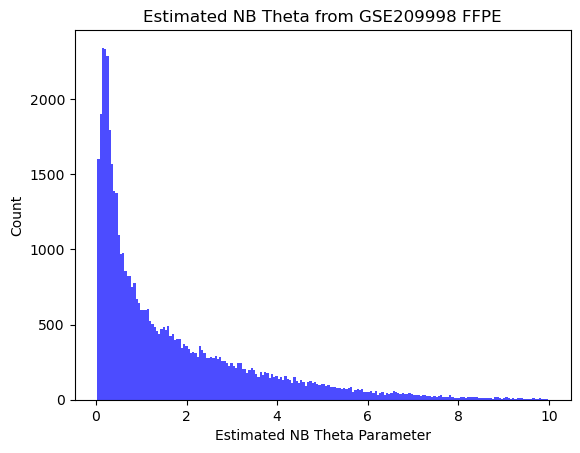

Mean: 1.7183498007307345 0.0 597.1725364709623
Median: 0.9903546250843883 0.0 14.13888888888889
Stdev: 1.9558605989036795 0.0 9665.226424594151
95% Percentiles: 0.07026384791871512, 6.805100517616221


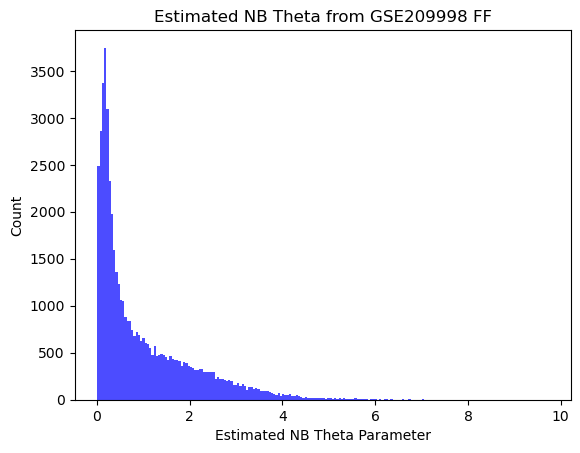

Mean: 1.0145378170810133 0.0 1380.8474203561148
Median: 0.5559068843913155 0.0 13.46236559139785
Stdev: 1.4700021533605563 0.0 44664.07569574267
95% Percentiles: 0.040242327972681666, 3.7455219308843355


In [32]:
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE209998_third_party_ffpe/GSE209998_GeneCount.rds')
sample_information = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE209998_third_party_ffpe/GSE209998_Sample_Data.rds')

# now we want to isolate just the expression from a particular type of tissue
df_counts = all_counts[None] # load all_counts into a pandas data frame
df_sample = sample_information[None] # load all_counts into a pandas data frame

# here, we need to match if a sample is normal or tumour by !Sample_source_name_ch1 row

# so I need to: 1) match columns between sample_information and all_counts 
# are they in the same order
columns_df1 = df_counts.columns
columns_df2 = df_sample.columns

# Now we find what samples were tumours and what were normal
samples_row = df_sample.loc["!Sample_source_name_ch1"]

split_dfs = {}
for sample_type in samples_row.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and samples_row[col] == sample_type]
    split_dfs[sample_type] = df_counts[matching_columns]

sample_source = df_sample.loc["!Sample_source"]

split_source = {}
for sample_type in sample_source.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and sample_source[col] == sample_type]
    split_source[sample_type] = df_counts[matching_columns]


count_FRESH = split_source["Fresh frozen"]
count_FFPE = split_source["FFPE"]

#filtered_ffpe = count_FFPE[count_FFPE.sum(axis=1) > 1]
# adjust for library size (fraction method)
count_FFPE_libadjust = library_adjust(count_FFPE)
fraction_of_zeroes = (count_FFPE_libadjust == 0).mean(axis=1)
filtered_ffpe = np.round(count_FFPE_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients

# adjust for library size (fraction method)
count_FRESH_libadjust = library_adjust(count_FRESH)
fraction_of_zeroes = (count_FRESH_libadjust == 0).mean(axis=1)
filtered_fresh = np.round(count_FRESH_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients


computed_values_nb = filtered_ffpe.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta[nb_theta < 10], bins=200, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,10)
plt.title("Estimated NB Theta from GSE209998 FFPE")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


# FF

computed_values_nb = filtered_fresh.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta[nb_theta < 10], bins=200, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,10)
plt.title("Estimated NB Theta from GSE209998 FF")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")




Giant Theta! (MOM)
Giant Theta! (MOM)


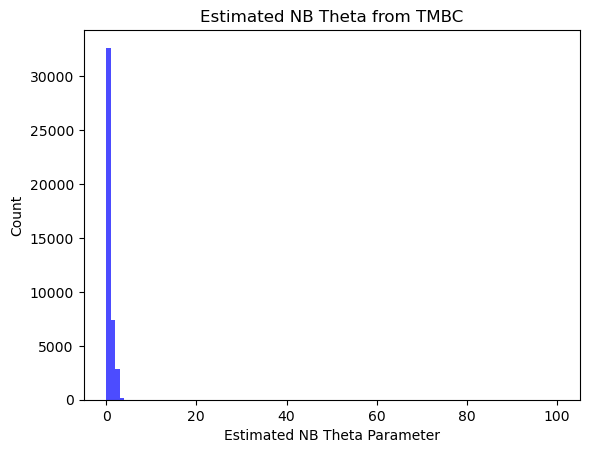

Mean: 0.6326813833065702 0.0 1003.3781153910321
Median: 0.3069276396834236 0.0 6.1
Stdev: 0.9930227935893166 0.0 21966.895183180193
Min, Max, Over10, Under0, Total
0.00480373457777267 100.0 3 0 43099 0.006960718346133321
3029 43099 0.07028005290145943
7339 43099 0.17028237314090813
theta 0.1 to 1 20707 43099 0.4804519826446089
theta 0.1 to 10 31167 43099 0.7231490289797907
theta 0.005 to 1 4590 43099 0.1064989906958398
Min, Max, Over10, Under0, Total
0 0 0 0 43099 0.0
95% Percentiles: 0.009523809523809504, 2.4692271449583054


In [34]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/CountMeIn_BConly_third_party_ffpe/MBC_CMI_Compiled_Counts.tsv',
                  delimiter=' ') # space delimited


tumours_counts = pd.DataFrame(data)


tumours_counts = tumours_counts[tumours_counts['gene_type'].notna()]
tumours_counts.set_index('gene_name', inplace=True)
tumours_counts = tumours_counts.drop(tumours_counts.columns[:2], axis=1) # columns 1-3 should be ignored

# library adjust; remove genes expressed < express_percent_limit
tumours_counts_libadjust = library_adjust(tumours_counts)
fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


computed_values_nb = filtered_df.apply(lambda row: estimate_nb_parameters(row), axis=1)
computed_values_nb = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*computed_values_nb)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta).astype(float)
ll_theta = np.array(ll_theta)

plt.hist(nb_theta, bins=100, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from TMBC")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))

count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


In [39]:
# Some datasets need to be split by patients
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE47462_third_party_ffpe/GSE47462_Raw_counts_Refseq_genes.txt',
                  delimiter='\t')
# Split the DataFrame into subsets based on column names indicating sample type
normal_data = data.filter(like='_normal')
EN_data = data.filter(like='_EN')
DCIS_data = data.filter(like='_DCIS')
IDC_data = data.filter(like='_IDC')

# since there isn't a ton of data, I also want to group tumors
tumours_data = data.loc[:, ~data.columns.str.contains('_normal')]
tumours_data = tumours_data.iloc[:, 1:]

#filtered_tumour = tumours_counts[tumours_counts.sum(axis=1) > 1]
#filtered_normal = normal_counts[normal_counts.sum(axis=1) > 1]

# adjust for library size (fraction method)
#tumours_data_libadjust = library_adjust(tumours_data)
fraction_of_zeroes = (tumours_data == 0).mean(axis=1)
filtered_tumour = tumours_data[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

#normal_data_libadjust = library_adjust(normal_data)
fraction_of_zeroes = (normal_data == 0).mean(axis=1)
filtered_normal = normal_data[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print(filtered_tumour.shape)
print(filtered_normal.shape)


(20644, 48)
(19497, 24)


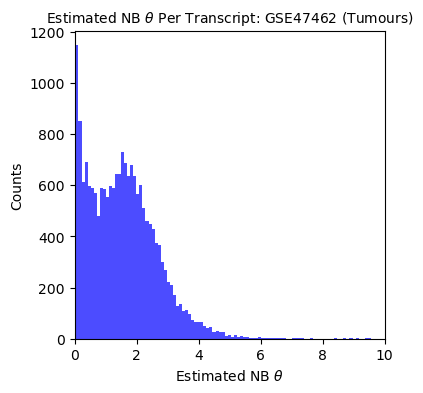

Mean: 1.6284846414790137 0.0 184.14701715572116
Median: 1.4806989764336573 0.0 18.854166666666668
Stdev: 2.833068779518178 0.0 733.9167052852162
Min, Max, Over10, Under0, Total
0.02186173614745043 287.8750000000041 50 0 19323 0.25875899187496765
0 19323 0.0
382 19323 0.019769186979247528
theta 0.1 to 1 5685 19323 0.29420897376183824
theta 0.1 to 10 18276 19323 0.9458158671013818
theta 0.005 to 1 615 19323 0.03182735600062102
Min, Max, Over10, Under0, Total
0 0 0 0 19323 0.0
95% Percentiles: 0.0571646468670795, 4.065412160734654
Giant Theta! (MOM)
Giant Theta! (MOM)


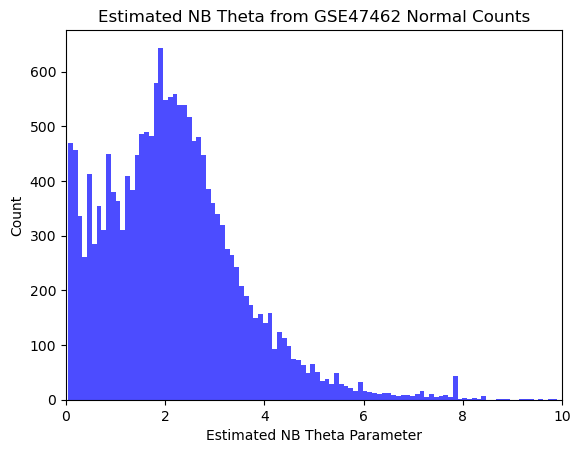

Mean: 2.284683248563331 0.0 180.97005318250888
Median: 2.0582996906799136 0.0 21.791666666666668
Stdev: 2.9186730688276366 0.0 695.827819969905
Min, Max, Over10, Under0, Total
0.04252078310512669 242.93749999999892 106 0 17769 0.5965445438685351
0 17769 0.0
23 17769 0.0012943891046204063
theta 0.1 to 1 3359 17769 0.18903708706173672
theta 0.1 to 10 17310 17769 0.9741684956947493
theta 0.005 to 1 330 17769 0.01857166976194496
Min, Max, Over10, Under0, Total
0 0 0 0 17769 0.0
95% Percentiles: 0.1292923382784091, 5.6385203365467165


In [ ]:
# tumours
computed_values_nb = filtered_tumour.apply(lambda row: estimate_nb_parameters(row), axis=1)

#df_filtered = computed_values_nb.dropna(subset=['nb_mu', 'nb_theta', 'ml_theta'])
filtered_values = [tup for tup in computed_values_nb if None not in tup]

nb_mu, nb_theta, ll_theta = zip(*filtered_values)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)


plt.figure(figsize=(4,4))
plt.hist(nb_theta[nb_theta < 100], bins=1000, color='blue', alpha=0.7)
plt.xlabel(r'Estimated NB $\theta$')
plt.ylabel('Counts')
plt.xlim(0,10)
plt.title(r"Estimated NB $\theta$ Per Transcript: GSE47462 (Tumours)", fontsize=10)

outpath = "/path/to/6.9-estimate_nb_parameters/"
plt.savefig(outpath + "histogram.NB_Parameter_Est.GSE47462_Tumours.pdf", format='pdf', dpi=600)

plt.show()


print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


# NORMALS
computed_values_nb = filtered_normal.apply(lambda row: estimate_nb_parameters(row), axis=1)
filtered_values = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*filtered_values)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)



plt.hist(nb_theta[nb_theta < 100], bins=1000, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
plt.xlim(0,10)
plt.title("Estimated NB Theta from GSE47462 Normal Counts")
plt.show()


print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)

#percentile_5 = np.percentile(nb_theta[nb_theta > 0], 5)
percentiles = np.percentile(nb_theta, [2.5, 97.5])

print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")


In [37]:
## GSE146889 split by tumour and normals
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE146889_third_party_ffpe/GSE146889_GeneCount.rds')
df = all_counts[None] # load all_counts into a pandas data frame

# we need to split the tumors and normals by name
count_TUMOR = df.filter(like='tumor')
count_NORMAL = df.filter(like='normal')

#filtered_tumour = count_TUMOR[count_TUMOR.sum(axis=1) > 1]
#filtered_normal = count_NORMAL[count_NORMAL.sum(axis=1) > 1]

# adjust for library size (fraction method)
#count_TUMOR_libadjust = library_adjust(count_TUMOR)

fraction_of_zeroes = (count_TUMOR == 0).mean(axis=1)
filtered_tumour = count_TUMOR[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

#print(dataset_stats)
# adjust for library size (fraction method)
#count_NORMAL_libadjust = library_adjust(count_NORMAL)

fraction_of_zeroes = (count_NORMAL == 0).mean(axis=1)
filtered_normal = count_NORMAL[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients



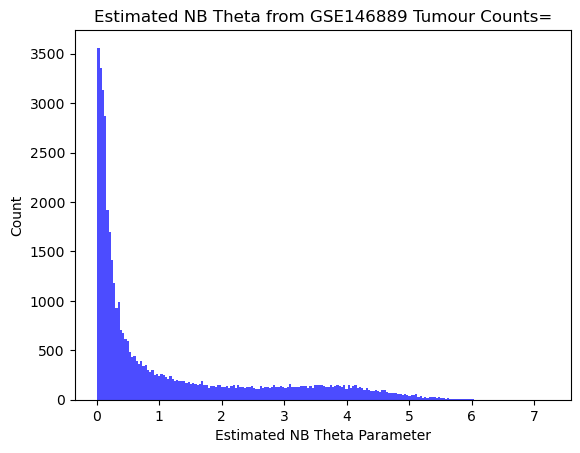

Mean: 1.1732412822630907 0.0 892.360107440746
Median: 0.4166652417394069 0.0 7.527472527472527
Stdev: 1.4378647489049905 0.0 8049.7534971103605
Min, Max, Over10, Under0, Total
0.011089579789241343 7.223652523583122 0 0 43788 0.0
787 43788 0.01797296062848269
3663 43788 0.0836530556316799
theta 0.1 to 1 19659 43788 0.44895861879967114
theta 0.1 to 10 35127 43788 0.8022060838585914
theta 0.005 to 1 4998 43788 0.11414086050972869
Min, Max, Over10, Under0, Total
0 0 0 0 43788 0.0
95% Percentiles: 0.021978021978022007, 4.6838965017088015


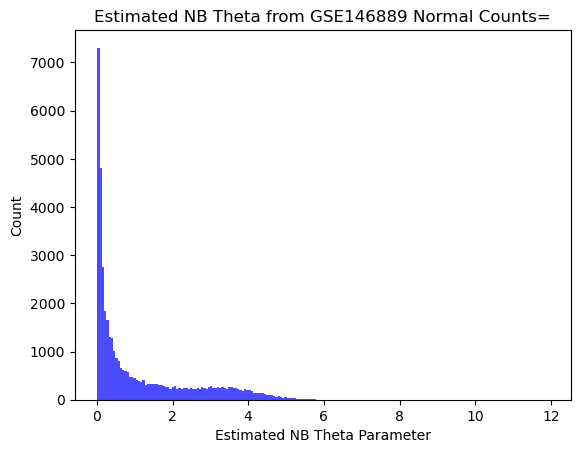

Mean: 1.1398167190003665 0.0 958.0337166335685
Median: 0.4587028904756899 0.0 7.2823529411764705
Stdev: 1.3548773378332315 0.0 9779.53408213955
Min, Max, Over10, Under0, Total
0.01177660143936242 11.929411764706096 2 0 42950 0.004656577415599534
1021 42950 0.023771827706635624
4673 42950 0.10880093131548312
theta 0.1 to 1 17542 42950 0.40842840512223516
theta 0.1 to 10 33165 42950 0.7721769499417928
theta 0.005 to 1 5110 42950 0.1189755529685681
Min, Max, Over10, Under0, Total
0 0 0 0 42950 0.0
95% Percentiles: 0.021177598941635935, 4.410557893617146


In [38]:
# tumours
computed_values_nb = filtered_tumour.apply(lambda row: estimate_nb_parameters(row), axis=1)
filtered_values = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*filtered_values)
nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)


plt.hist(nb_theta, bins=200, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE146889 Tumour Counts=")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))
counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)


percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")

# NORMALS
computed_values_nb = filtered_normal.apply(lambda row: estimate_nb_parameters(row), axis=1)
filtered_values = [tup for tup in computed_values_nb if None not in tup]
nb_mu, nb_theta, ll_theta = zip(*filtered_values)

nb_mu = np.array(nb_mu).astype(float)
nb_theta = np.array(nb_theta)
ll_theta = np.array(ll_theta)



plt.hist(nb_theta, bins=200, color='blue', alpha=0.7)
plt.xlabel('Estimated NB Theta Parameter')
plt.ylabel('Count')
#plt.xlim(0,100)
plt.title("Estimated NB Theta from GSE146889 Normal Counts=")
plt.show()

print("Mean:", np.mean(nb_theta), np.mean(ll_theta), np.mean(nb_mu))
print("Median:", np.median(nb_theta), np.median(ll_theta), np.median(nb_mu))
print("Stdev:", np.std(nb_theta), np.std(ll_theta), np.std(nb_mu))
count_in_range = np.sum((nb_theta > 10))
underdispersion = np.sum(nb_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(nb_theta), np.max(nb_theta), count_in_range, underdispersion, len(nb_theta), (count_in_range/len(nb_theta))*100)

counts_near_01 = np.sum((nb_theta >= 0) & (nb_theta < 0.02))
print(counts_near_01, len(nb_theta), counts_near_01/len(nb_theta))

counts_below_05 = np.sum((nb_theta >= 0) & (nb_theta < 0.05))
print(counts_below_05, len(nb_theta), counts_below_05/len(nb_theta))

counts_between_01_1 = np.sum((nb_theta >= 0.1) & (nb_theta <= 1))
print("theta 0.1 to 1", counts_between_01_1, len(nb_theta), counts_between_01_1/len(nb_theta))
counts_between_01_10 = np.sum((nb_theta >= 0.1) & (nb_theta <= 10))
print("theta 0.1 to 10", counts_between_01_10, len(nb_theta), counts_between_01_10/len(nb_theta))
counts_between_005_01 = np.sum((nb_theta >= 0.05) & (nb_theta <= 0.1))
print("theta 0.005 to 1", counts_between_005_01, len(nb_theta), counts_between_005_01/len(nb_theta))

count_in_range = np.sum((ll_theta > 10))
underdispersion = np.sum(ll_theta < 0)
print("Min, Max, Over10, Under0, Total")
print(np.min(ll_theta), np.max(ll_theta), count_in_range, underdispersion, len(ll_theta), (count_in_range/len(ll_theta))*100)


percentiles = np.percentile(nb_theta, [2.5, 97.5])
print(f"95% Percentiles: {percentiles[0]}, {percentiles[1]}")